# **Feature Engineering of the Proposals Data**

**Purpose:** prepare the proposals data for the two modelling problems that were identified during EDA: RFS and All.
The modelling that this data will be supporting is a one-off exploration of factors influencing proposal outcomes, so the below is not built in a pipeline fashion

**Next Steps:** Modelling for ALL and RFS proposals

# **File Setup**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [6]:
from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   prop = pd.read_csv(io.BytesIO(file_content))
   prop.set_index(prop.columns[0], inplace=True)

print(prop.shape)

Saving 2.1 EDA Output.csv to 2.1 EDA Output.csv
(2227, 26)


In [7]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2227 entries, 0 to 2274
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   proposal_num     2223 non-null   object 
 1   registry_region  2227 non-null   object 
 2   sow              2227 non-null   object 
 3   rfp              2227 non-null   int64  
 4   units_orig       2107 non-null   object 
 5   storeys_orig     2042 non-null   object 
 6   townhouse_orig   1980 non-null   object 
 7   parking_orig     1996 non-null   object 
 8   prev_rfs         2227 non-null   object 
 9   reminder         2224 non-null   object 
 10  fee_probable     2225 non-null   float64
 11  issued_date      2227 non-null   object 
 12  outcome          2227 non-null   int64  
 13  prev_wins        2227 non-null   float64
 14  townhouse_flag   2227 non-null   int64  
 15  storeys          910 non-null    float64
 16  comm_flag        2227 non-null   float64
 17  comm_units       18

In [8]:
#We'll remove the columns that were not identified as significant during EDA
prop = prop[['region', 'prev_rfs', 'reminder', 'fee_probable', 'outcome', 'project_type', 'building_type', 'units','sow']]

In [9]:
prop.head()

,region,prev_rfs,reminder,fee_probable,outcome,project_type,building_type,units,sow
Unnamed: 0,,,,,,,,,
0,TOR,Yes,No,2795.0,1,RFS,unknown,NaN,Update RFS
1,TOR,No,No,2500.0,0,RFS,residential,39.0,Class 2 RFS
2,TOR,Yes,Yes,3795.0,1,RFS,highrise,46.0,Update RFS
3,Unknown,Yes,No,1508.0,1,RFS,unknown,NaN,Class 3 RFS
4,TOR,Yes,No,5825.0,0,RFS,highrise,320.0,Class 2 RFS


# **Classifier: outcome**

outcome is the the final classification that we will be looking to predict for both the RFS and ALL models. This column has already been cleaned, but lets take a look again just to make sure it is good to go from a modelling perspective

In [10]:
prop['outcome'].value_counts(dropna=False)

,count
outcome,
0,1125
1,1102


Confirmed that there are no nulls in this column and everything is classified as 0 for loss or 1 for win

# **ALL Model Feature Prep**

This model will be applied across all project types

There were only three columns that were identified as usable for All projects types:
*   region
*   fee_probable
*   project_type








The grouping of the project_type column was called into question during EDA, so we will also bring in 'sow' to help evaluate and refine the grouping

In [11]:
all = prop[['region', 'fee_probable', 'project_type', 'outcome', 'sow']]

In [12]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2227 entries, 0 to 2274
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        2227 non-null   object 
 1   fee_probable  2225 non-null   float64
 2   project_type  2227 non-null   object 
 3   outcome       2227 non-null   int64  
 4   sow           2227 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 104.4+ KB


In [13]:
all = all.reset_index(drop = False)

In [14]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2227 non-null   int64  
 1   region        2227 non-null   object 
 2   fee_probable  2225 non-null   float64
 3   project_type  2227 non-null   object 
 4   outcome       2227 non-null   int64  
 5   sow           2227 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 104.5+ KB


**project_type**

In [15]:
all['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1320
Consult,181
Envelope,144
Roofing,105
Other,95
Garage,92
PCA,91
PA & Class 1 RFS,84
BCA,70


During EDA, project_type was found to have impact, but it was also found to be perhaps a bit too high-level. We will be evaluating whether the project_types can be better grouped using the sow column. To this end, we'll start with one-hot encoding both the project_type and will revisit this later

In [16]:
all = pd.get_dummies(all, columns=['project_type'], prefix = 'project_type')

In [17]:
all.head()

,Unnamed: 0,region,fee_probable,outcome,sow,project_type_BCA,project_type_Consult,project_type_Envelope,project_type_Garage,project_type_Mechanical,project_type_Other,project_type_PA & Class 1 RFS,project_type_PCA,project_type_RFS,project_type_Roofing
0,0,TOR,2795.0,1,Update RFS,False,False,False,False,False,False,False,False,True,False
1,1,TOR,2500.0,0,Class 2 RFS,False,False,False,False,False,False,False,False,True,False
2,2,TOR,3795.0,1,Update RFS,False,False,False,False,False,False,False,False,True,False
3,3,Unknown,1508.0,1,Class 3 RFS,False,False,False,False,False,False,False,False,True,False
4,4,TOR,5825.0,0,Class 2 RFS,False,False,False,False,False,False,False,False,True,False


**sow**

In [18]:
all['sow'].describe()

,sow
count,2227
unique,31
top,Class 2 RFS
freq,815


In [19]:
all['sow'].value_counts(dropna=False)

,count
sow,
Class 2 RFS,815
Update RFS,447
Consult,181
Roofing,105
Garage,92
PCA,91
PA & Class 1 RFS,84
BCA,66
Envelope,64


We'll group anything under 20 as 'Other'

In [20]:
counts = all['sow'].value_counts()
mask = all['sow'].isin(counts[counts < 20].index)
all.loc[mask, 'sow'] = 'Other'

In [21]:
all['sow'].describe()

,sow
count,2227
unique,16
top,Class 2 RFS
freq,815


Now the column is ready to be made into dummies

In [22]:
all = pd.get_dummies(all, columns=['sow'], prefix = 'sow')

**Region**

This column has already been cleaned since it was grouped from a more detailed indicator. We'll check for completeness just in case

In [23]:
all['region'].value_counts(dropna=False)

,count
region,
TOR,1205
EO,331
Unknown,326
HUR,243
GH,91
LON,13
GR,12
WIN,6


In [24]:
#Lets roll the low-count regions into an 'Other' category
all['region'] = all['region'].replace({
    'WIN': 'Other',
    'GR': 'Other',
    'LON': 'Other'
})

In [25]:
all['region'].value_counts(dropna=False)

,count
region,
TOR,1205
EO,331
Unknown,326
HUR,243
GH,91
Other,31


Ready for one-hot encoding

In [26]:
#one-hot encode the region column
all = pd.get_dummies(all, columns=['region'], prefix = 'region')

In [27]:
all.head()

,Unnamed: 0,fee_probable,outcome,project_type_BCA,project_type_Consult,project_type_Envelope,project_type_Garage,project_type_Mechanical,project_type_Other,project_type_PA & Class 1 RFS,...,sow_Pavement,sow_Roofing,sow_Structural,sow_Update RFS,region_EO,region_GH,region_HUR,region_Other,region_TOR,region_Unknown
0,0,2795.0,1,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,1,2500.0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2,3795.0,1,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
3,3,1508.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,4,5825.0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


**fee_probable**

In [28]:
#Let's start by dropping the two rows with nulls in the fee_probable column
all = all.dropna(subset=['fee_probable'])

In [29]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 0 to 2226
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     2225 non-null   int64  
 1   fee_probable                   2225 non-null   float64
 2   outcome                        2225 non-null   int64  
 3   project_type_BCA               2225 non-null   bool   
 4   project_type_Consult           2225 non-null   bool   
 5   project_type_Envelope          2225 non-null   bool   
 6   project_type_Garage            2225 non-null   bool   
 7   project_type_Mechanical        2225 non-null   bool   
 8   project_type_Other             2225 non-null   bool   
 9   project_type_PA & Class 1 RFS  2225 non-null   bool   
 10  project_type_PCA               2225 non-null   bool   
 11  project_type_RFS               2225 non-null   bool   
 12  project_type_Roofing           2225 non-null   bool  

In [30]:
all['fee_probable'].describe()

,fee_probable
count,2225.000000
mean,7905.606930
std,26689.000436
min,195.000000
25%,2400.000000
50%,3295.000000
75%,5190.000000
max,598770.000000


The distribution of this column is extremely left-skewed with a high number of outliers on the right. During EDA the attempts to describe the shape were not successful, so we will have to bucket the values

We need to do this transformation after splitting the dataset into train/test this will bee done in the next section

# **ALL Model Transformations**

The ALL model data is ready for transformations now

In [31]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 0 to 2226
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     2225 non-null   int64  
 1   fee_probable                   2225 non-null   float64
 2   outcome                        2225 non-null   int64  
 3   project_type_BCA               2225 non-null   bool   
 4   project_type_Consult           2225 non-null   bool   
 5   project_type_Envelope          2225 non-null   bool   
 6   project_type_Garage            2225 non-null   bool   
 7   project_type_Mechanical        2225 non-null   bool   
 8   project_type_Other             2225 non-null   bool   
 9   project_type_PA & Class 1 RFS  2225 non-null   bool   
 10  project_type_PCA               2225 non-null   bool   
 11  project_type_RFS               2225 non-null   bool   
 12  project_type_Roofing           2225 non-null   bool  

train-test-split

In [32]:
X = all.drop('outcome', axis=1)
y = all['outcome']

In [33]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=37)

**probable_ fee**

Given the extreme left skew of our data, we're going to use log-binning which does not need the data to be standardized

In [34]:
X_train_all['log_fee'] = np.log1p(X_train_all['fee_probable'])

def log_bins(data, num_bins):
    min_val = data.min() + 1
    max_val = data.max()
    bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
    return pd.cut(data, bins=bin_edges, labels=False)

X_train_all['log_fee_binned'] = log_bins(X_train_all['log_fee'], num_bins=10)

In [35]:
pd.pivot_table(X_train_all, index='log_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
log_fee_binned,,,
0.0,645.0,880.0,14
1.0,932.0,1650.0,74
2.0,1685.0,3145.0,718
3.0,3195.0,6400.0,655
4.0,6450.0,13663.0,177
5.0,13750.0,30900.0,75
6.0,31500.0,74850.0,32
7.0,80101.0,194000.0,20


Text(0.5, 1.0, 'Distribution of Fee Bins')

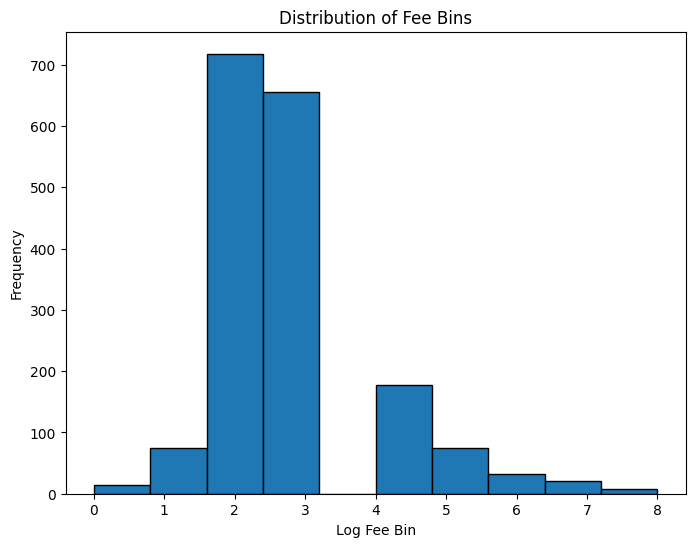

In [36]:
plt.figure(figsize=(8, 6))
plt.hist(X_train_all['log_fee_binned'], bins=10, edgecolor='k')
plt.xlabel('Log Fee Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Fee Bins')

The data is bunched to the left without much discernable groupings in the numbers, so we're going to try equal frequency binning

In [37]:
X_train_all['equal_fee_binned'], bin_edges = pd.qcut(X_train_all['fee_probable'], q=10, labels=False, retbins=True)

In [38]:
pd.pivot_table(X_train_all, index='equal_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
equal_fee_binned,,,
0,195.0,1995.0,218
1,2000.0,2295.0,172
2,2300.0,2595.0,154
3,2600.0,2950.0,169
4,2965.0,3295.0,199
5,3345.0,3895.0,164
6,3900.0,4695.0,177
7,4700.0,5990.0,172


The results from equal frequency binning seem more fitting and explainable, so let's apply this to out train and test data

In [39]:
X_train_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1780 entries, 1379 to 1936
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1780 non-null   int64  
 1   fee_probable                   1780 non-null   float64
 2   project_type_BCA               1780 non-null   bool   
 3   project_type_Consult           1780 non-null   bool   
 4   project_type_Envelope          1780 non-null   bool   
 5   project_type_Garage            1780 non-null   bool   
 6   project_type_Mechanical        1780 non-null   bool   
 7   project_type_Other             1780 non-null   bool   
 8   project_type_PA & Class 1 RFS  1780 non-null   bool   
 9   project_type_PCA               1780 non-null   bool   
 10  project_type_RFS               1780 non-null   bool   
 11  project_type_Roofing           1780 non-null   bool   
 12  sow_BCA                        1780 non-null   boo

In [40]:
#drop fee_probable, log_fee and log_fee binned from X_train
X_train_all = X_train_all.drop(['fee_probable', 'log_fee', 'log_fee_binned'], axis=1)

In [41]:
#Apply the binning to X_test
X_test_all['equal_fee_binned'] = pd.cut(X_test_all['fee_probable'], bins=bin_edges, labels=False, include_lowest=True)

In [42]:
#This matches our trainign bins, so we can now drop fee_probable
pd.pivot_table(X_test_all, index='equal_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
equal_fee_binned,,,
0,215.0,1995.0,61
1,2000.0,2295.0,34
2,2340.0,2595.0,46
3,2690.0,2950.0,39
4,2990.0,3295.0,57
5,3395.0,3895.0,36
6,3950.0,4695.0,45
7,4720.0,5990.0,37


In [43]:
X_test_all = X_test_all.drop('fee_probable', axis=1)

In [44]:
#convert the fee bins to dummy variables
X_train_all = pd.get_dummies(X_train_all, columns=['equal_fee_binned'], prefix = 'fee')
X_test_all = pd.get_dummies(X_test_all, columns=['equal_fee_binned'], prefix = 'fee')

In [45]:
X_train_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1780 entries, 1379 to 1936
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Unnamed: 0                     1780 non-null   int64
 1   project_type_BCA               1780 non-null   bool 
 2   project_type_Consult           1780 non-null   bool 
 3   project_type_Envelope          1780 non-null   bool 
 4   project_type_Garage            1780 non-null   bool 
 5   project_type_Mechanical        1780 non-null   bool 
 6   project_type_Other             1780 non-null   bool 
 7   project_type_PA & Class 1 RFS  1780 non-null   bool 
 8   project_type_PCA               1780 non-null   bool 
 9   project_type_RFS               1780 non-null   bool 
 10  project_type_Roofing           1780 non-null   bool 
 11  sow_BCA                        1780 non-null   bool 
 12  sow_Balcony                    1780 non-null   bool 
 13  sow_Class 1 RFS     

In [46]:
X_test_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 1675 to 2015
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Unnamed: 0                     445 non-null    int64
 1   project_type_BCA               445 non-null    bool 
 2   project_type_Consult           445 non-null    bool 
 3   project_type_Envelope          445 non-null    bool 
 4   project_type_Garage            445 non-null    bool 
 5   project_type_Mechanical        445 non-null    bool 
 6   project_type_Other             445 non-null    bool 
 7   project_type_PA & Class 1 RFS  445 non-null    bool 
 8   project_type_PCA               445 non-null    bool 
 9   project_type_RFS               445 non-null    bool 
 10  project_type_Roofing           445 non-null    bool 
 11  sow_BCA                        445 non-null    bool 
 12  sow_Balcony                    445 non-null    bool 
 13  sow_Class 1 RFS      

The ALL data is now ready for modelling

# **RFS Model Feature Prep**

The model will be applied to proposals for Reserve Fund Studies. The data is consistently much more complete for this project type, so there are more features that will be included
*   region
*   fee_probable
*   sow
*   prev_rfs
*   reminder
*   building_type
*   units

project_type has been excluded from this list since it would be RFS for all records


**SOW**

This is the column we'll use to identify projects that are RFSs

In [47]:
#From the below list we'll be using Class 2 RFS, Update RFS, PA & Class 1 RFS, Class 1 RFS and Class 3 RFS
prop['sow'].value_counts(dropna=False)

,count
sow,
Class 2 RFS,815
Update RFS,447
Consult,181
Roofing,105
Garage,92
PCA,91
PA & Class 1 RFS,84
BCA,66
Envelope,64


In [48]:
#create a new df rfs with all records where prop sow column = Class 2 RFS, Update RFS, PA & Class 1 RFS, Class 1 RFS and Class 3 RFS
rfs = prop[prop['sow'].isin(['Class 2 RFS', 'Update RFS', 'PA & Class 1 RFS', 'Class 1 RFS', 'Class 3 RFS'])]

In [49]:
rfs['sow'].value_counts(dropna=False)

,count
sow,
Class 2 RFS,815
Update RFS,447
PA & Class 1 RFS,84
Class 1 RFS,42
Class 3 RFS,16


In [50]:
#We are left with 1404 records, and can already see that units is the only column where we will have nulls to deal with
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 2274
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         1404 non-null   object 
 1   prev_rfs       1404 non-null   object 
 2   reminder       1404 non-null   object 
 3   fee_probable   1404 non-null   float64
 4   outcome        1404 non-null   int64  
 5   project_type   1404 non-null   object 
 6   building_type  1404 non-null   object 
 7   units          1286 non-null   float64
 8   sow            1404 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 109.7+ KB


In [51]:
#We'll convert the sow column to dummies
rfs = pd.get_dummies(rfs, columns=['sow'], prefix = 'sow')

In [52]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 2274
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   region                1404 non-null   object 
 1   prev_rfs              1404 non-null   object 
 2   reminder              1404 non-null   object 
 3   fee_probable          1404 non-null   float64
 4   outcome               1404 non-null   int64  
 5   project_type          1404 non-null   object 
 6   building_type         1404 non-null   object 
 7   units                 1286 non-null   float64
 8   sow_Class 1 RFS       1404 non-null   bool   
 9   sow_Class 2 RFS       1404 non-null   bool   
 10  sow_Class 3 RFS       1404 non-null   bool   
 11  sow_PA & Class 1 RFS  1404 non-null   bool   
 12  sow_Update RFS        1404 non-null   bool   
dtypes: bool(5), float64(2), int64(1), object(5)
memory usage: 105.6+ KB


***region***

We already checked this one for the ALL model data,

In [53]:
rfs['region'].value_counts(dropna=False)

,count
region,
TOR,875
HUR,216
EO,213
GH,64
Unknown,15
GR,10
LON,8
WIN,3


In [54]:
#we'll apply the same goruping we did to the ALL data
rfs['region'] = rfs['region'].replace({
    'WIN': 'Other',
    'GR': 'Other',
    'LON': 'Other'
})

In [55]:
#create dummies
rfs = pd.get_dummies(rfs, columns=['region'], prefix = 'region')

In [56]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 2274
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              1404 non-null   object 
 1   reminder              1404 non-null   object 
 2   fee_probable          1404 non-null   float64
 3   outcome               1404 non-null   int64  
 4   project_type          1404 non-null   object 
 5   building_type         1404 non-null   object 
 6   units                 1286 non-null   float64
 7   sow_Class 1 RFS       1404 non-null   bool   
 8   sow_Class 2 RFS       1404 non-null   bool   
 9   sow_Class 3 RFS       1404 non-null   bool   
 10  sow_PA & Class 1 RFS  1404 non-null   bool   
 11  sow_Update RFS        1404 non-null   bool   
 12  region_EO             1404 non-null   bool   
 13  region_GH             1404 non-null   bool   
 14  region_HUR            1404 non-null   bool   
 15  region_Other          1404

**prev_rfs**

In [57]:
rfs['prev_rfs'].value_counts(dropna=False)

,count
prev_rfs,
No,748
Yes,656


In [58]:
#We'll convert this to 1 and 0
rfs['prev_rfs'] = rfs['prev_rfs'].replace({'No': 0, 'Yes': 1})

<ipython-input-58-a839b01b9d29>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rfs['prev_rfs'] = rfs['prev_rfs'].replace({'No': 0, 'Yes': 1})


In [59]:
rfs['prev_rfs'].value_counts(dropna=False)

,count
prev_rfs,
0,748
1,656


***reminder***

In [60]:
rfs['reminder'].value_counts(dropna=False)

,count
reminder,
No,931
Yes,473


In [61]:
#we'll convert this too binary as well
rfs['reminder'] = rfs['reminder'].replace({'No': 0, 'Yes': 1})

<ipython-input-61-5a9f03d97515>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rfs['reminder'] = rfs['reminder'].replace({'No': 0, 'Yes': 1})


In [62]:
rfs['reminder'].value_counts(dropna=False)

,count
reminder,
0,931
1,473


**building_type**

In [63]:
rfs['building_type'].value_counts(dropna=False)

,count
building_type,
highrise,422
townhouse,388
unknown,171
residential,144
commercial,140
potl,110
mixed_use,29


In [64]:
#We'll convert this to dummy variables
rfs = pd.get_dummies(rfs, columns=['building_type'], prefix = 'building')

In [65]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 2274
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              1404 non-null   int64  
 1   reminder              1404 non-null   int64  
 2   fee_probable          1404 non-null   float64
 3   outcome               1404 non-null   int64  
 4   project_type          1404 non-null   object 
 5   units                 1286 non-null   float64
 6   sow_Class 1 RFS       1404 non-null   bool   
 7   sow_Class 2 RFS       1404 non-null   bool   
 8   sow_Class 3 RFS       1404 non-null   bool   
 9   sow_PA & Class 1 RFS  1404 non-null   bool   
 10  sow_Update RFS        1404 non-null   bool   
 11  region_EO             1404 non-null   bool   
 12  region_GH             1404 non-null   bool   
 13  region_HUR            1404 non-null   bool   
 14  region_Other          1404 non-null   bool   
 15  region_TOR            1404

***project_type***

This is RFS for all records, so we we'll drop the column

In [66]:
rfs = rfs.drop('project_type', axis=1)

In [67]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 2274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              1404 non-null   int64  
 1   reminder              1404 non-null   int64  
 2   fee_probable          1404 non-null   float64
 3   outcome               1404 non-null   int64  
 4   units                 1286 non-null   float64
 5   sow_Class 1 RFS       1404 non-null   bool   
 6   sow_Class 2 RFS       1404 non-null   bool   
 7   sow_Class 3 RFS       1404 non-null   bool   
 8   sow_PA & Class 1 RFS  1404 non-null   bool   
 9   sow_Update RFS        1404 non-null   bool   
 10  region_EO             1404 non-null   bool   
 11  region_GH             1404 non-null   bool   
 12  region_HUR            1404 non-null   bool   
 13  region_Other          1404 non-null   bool   
 14  region_TOR            1404 non-null   bool   
 15  region_Unknown        1404

**units**

This feature is continuous, but similar to fee probable, is highly left skewed. We will have to bin it. We'll do this after the train/test split.

There are quite a few nulls in this column, but since this variable will be binned, that will remove this column. The nulls will simply not have a bin assigned to them

In [68]:
rfs['units'].isnull().sum()

118

# **RFS Model Transformations**

We'll split our data before apply transformations

In [69]:
X = rfs.drop('outcome', axis=1)
y = rfs['outcome']

In [70]:
X_train_rfs, X_test_rfs, y_train_rfs, y_test_rfs = train_test_split(X, y, test_size=0.2, random_state=37)

**Units**

This needs to be binned and converted to dummies.

In [71]:
print(X_train_rfs['units'].isnull().sum())
print(X_test_rfs['units'].isnull().sum())

89
29


The distribution is very similar to probable_fee, so it is doubtful that clustering will work to create meaningful buckets, but we'll try first just in case

In [72]:
X_train_rfs['log_units'] = np.log1p(X_train_rfs['units'])

def log_bins(data, num_bins):
    min_val = data.min()
    max_val = data.max()
    bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
    return pd.cut(data, bins=bin_edges, labels=False), bin_edges

X_train_rfs['log_units_binned'], bin_edges = log_bins(X_train_rfs['log_units'], num_bins=9)

In [73]:
pd.pivot_table(X_train_rfs, index='log_units_binned', values='units', aggfunc=['min', 'max', 'count'])

,min,max,count
,units,units,units
log_units_binned,,,
1.0,2.0,2.0,2
2.0,3.0,4.0,13
3.0,5.0,8.0,48
4.0,9.0,18.0,141
5.0,19.0,54.0,365
6.0,55.0,215.0,316
7.0,216.0,1343.0,146


Text(0.5, 1.0, 'Distribution of Unit Bins')

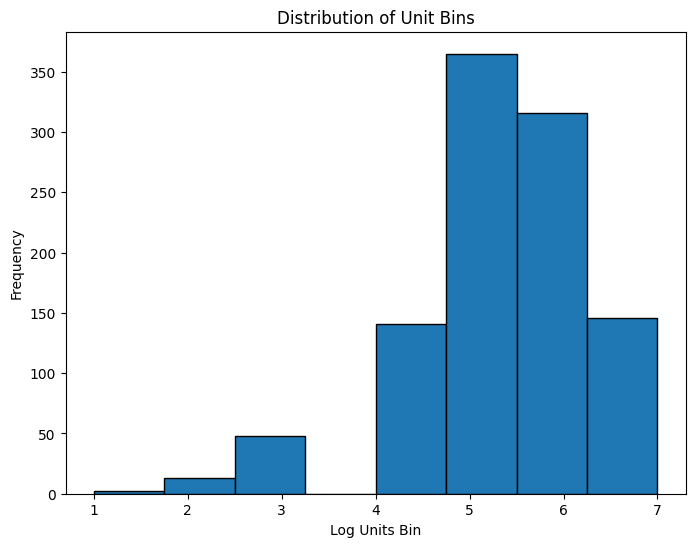

In [74]:
plt.figure(figsize=(8, 6))
plt.hist(X_train_rfs['log_units_binned'], bins=8, edgecolor='k')
plt.xlabel('Log Units Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Unit Bins')

While this isn't as drastically skewed as the ALL fee, it still isn't great. The bins on the left are very sparse. We'll try equal frequency again

In [75]:
X_train_rfs['equal_units_binned'], bin_edges = pd.qcut(X_train_rfs['units'], q=10, labels=False, retbins=True)

In [76]:
pd.pivot_table(X_train_rfs, index='equal_units_binned', values='units', aggfunc=['min', 'max', 'count'])

,min,max,count
,units,units,units
equal_units_binned,,,
0.0,1.0,12.0,132
1.0,13.0,18.0,75
2.0,19.0,26.0,113
3.0,27.0,35.0,96
4.0,36.0,47.0,103
5.0,48.0,66.0,105
6.0,67.0,97.0,102
7.0,98.0,150.0,105


In [77]:
X_test_rfs['equal_units_binned'] = pd.cut(X_test_rfs['units'], bins=bin_edges, labels=False, include_lowest=True)

In [78]:
X_test_rfs['equal_units_binned'].value_counts(dropna=False)

,count
equal_units_binned,
0.0,33
9.0,31
4.0,30
NaN,29
7.0,29
6.0,28
2.0,26
3.0,24
5.0,23


In [79]:
#drop the original units column
X_train_rfs = X_train_rfs.drop(['units', 'log_units', 'log_units_binned'], axis=1)
X_test_rfs = X_test_rfs.drop('units', axis=1)

Now we'll convert the binned units column dummies. Since get_dummies ignores nulls, when we convert this column the nulls will no longer be in our data

In [80]:
X_train_rfs = pd.get_dummies(X_train_rfs, columns=['equal_units_binned'], prefix = 'unit_bin')
X_test_rfs = pd.get_dummies(X_test_rfs, columns=['equal_units_binned'], prefix = 'unit_bin')

In [81]:
X_train_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1123 entries, 385 to 405
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              1123 non-null   int64  
 1   reminder              1123 non-null   int64  
 2   fee_probable          1123 non-null   float64
 3   sow_Class 1 RFS       1123 non-null   bool   
 4   sow_Class 2 RFS       1123 non-null   bool   
 5   sow_Class 3 RFS       1123 non-null   bool   
 6   sow_PA & Class 1 RFS  1123 non-null   bool   
 7   sow_Update RFS        1123 non-null   bool   
 8   region_EO             1123 non-null   bool   
 9   region_GH             1123 non-null   bool   
 10  region_HUR            1123 non-null   bool   
 11  region_Other          1123 non-null   bool   
 12  region_TOR            1123 non-null   bool   
 13  region_Unknown        1123 non-null   bool   
 14  building_commercial   1123 non-null   bool   
 15  building_highrise     112

In [82]:
X_test_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 281 entries, 1224 to 258
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              281 non-null    int64  
 1   reminder              281 non-null    int64  
 2   fee_probable          281 non-null    float64
 3   sow_Class 1 RFS       281 non-null    bool   
 4   sow_Class 2 RFS       281 non-null    bool   
 5   sow_Class 3 RFS       281 non-null    bool   
 6   sow_PA & Class 1 RFS  281 non-null    bool   
 7   sow_Update RFS        281 non-null    bool   
 8   region_EO             281 non-null    bool   
 9   region_GH             281 non-null    bool   
 10  region_HUR            281 non-null    bool   
 11  region_Other          281 non-null    bool   
 12  region_TOR            281 non-null    bool   
 13  region_Unknown        281 non-null    bool   
 14  building_commercial   281 non-null    bool   
 15  building_highrise     281

**fee_probable**

We'll bin this one similar to how we binned it for the ALL model

In [83]:
X_train_rfs['equal_fee_binned'], bin_edges = pd.qcut(X_train_rfs['fee_probable'], q=10, labels=False, retbins=True)

Text(0.5, 1.0, 'Distribution of Fee Bins')

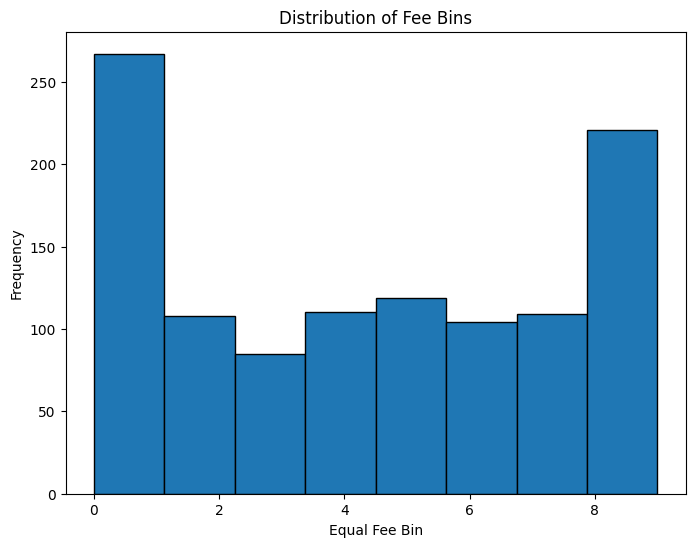

In [84]:
plt.figure(figsize=(8, 6))
plt.hist(X_train_rfs['equal_fee_binned'], bins=8, edgecolor='k')
plt.xlabel('Equal Fee Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Fee Bins')

In [85]:
pd.pivot_table(X_train_rfs, index='equal_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
equal_fee_binned,,,
0,932.0,1995.0,119
1,2080.0,2295.0,148
2,2300.0,2495.0,108
3,2500.0,2695.0,85
4,2750.0,2995.0,110
5,3095.0,3395.0,119
6,3445.0,3895.0,104
7,3990.0,4595.0,109


In [86]:
X_test_rfs['equal_fee_binned'] = pd.cut(X_test_rfs['fee_probable'], bins=bin_edges, labels=False, include_lowest=True)

In [87]:
X_test_rfs['equal_fee_binned'].value_counts()

,count
equal_fee_binned,
4,38
5,38
1,35
9,34
7,29
6,28
0,23
2,22
8,18


In [88]:
#Create dummies
X_train_rfs = pd.get_dummies(X_train_rfs, columns=['equal_fee_binned'], prefix = 'fee_bin')
X_test_rfs = pd.get_dummies(X_test_rfs, columns=['equal_fee_binned'], prefix = 'fee_bin')

In [89]:
#drop fee_probable column
X_train_rfs = X_train_rfs.drop('fee_probable', axis=1)
X_test_rfs = X_test_rfs.drop('fee_probable', axis=1)

In [90]:
X_train_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1123 entries, 385 to 405
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   prev_rfs              1123 non-null   int64
 1   reminder              1123 non-null   int64
 2   sow_Class 1 RFS       1123 non-null   bool 
 3   sow_Class 2 RFS       1123 non-null   bool 
 4   sow_Class 3 RFS       1123 non-null   bool 
 5   sow_PA & Class 1 RFS  1123 non-null   bool 
 6   sow_Update RFS        1123 non-null   bool 
 7   region_EO             1123 non-null   bool 
 8   region_GH             1123 non-null   bool 
 9   region_HUR            1123 non-null   bool 
 10  region_Other          1123 non-null   bool 
 11  region_TOR            1123 non-null   bool 
 12  region_Unknown        1123 non-null   bool 
 13  building_commercial   1123 non-null   bool 
 14  building_highrise     1123 non-null   bool 
 15  building_mixed_use    1123 non-null   bool 
 16  building_p

In [91]:
X_test_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 281 entries, 1224 to 258
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   prev_rfs              281 non-null    int64
 1   reminder              281 non-null    int64
 2   sow_Class 1 RFS       281 non-null    bool 
 3   sow_Class 2 RFS       281 non-null    bool 
 4   sow_Class 3 RFS       281 non-null    bool 
 5   sow_PA & Class 1 RFS  281 non-null    bool 
 6   sow_Update RFS        281 non-null    bool 
 7   region_EO             281 non-null    bool 
 8   region_GH             281 non-null    bool 
 9   region_HUR            281 non-null    bool 
 10  region_Other          281 non-null    bool 
 11  region_TOR            281 non-null    bool 
 12  region_Unknown        281 non-null    bool 
 13  building_commercial   281 non-null    bool 
 14  building_highrise     281 non-null    bool 
 15  building_mixed_use    281 non-null    bool 
 16  building_p

These are done and ready to go!

# **ALL Multicollinearity Check**

Before we finalize the data we'll check for correlation between features

In [97]:
correlation_matrix = X_train_all.corr()

<Axes: >

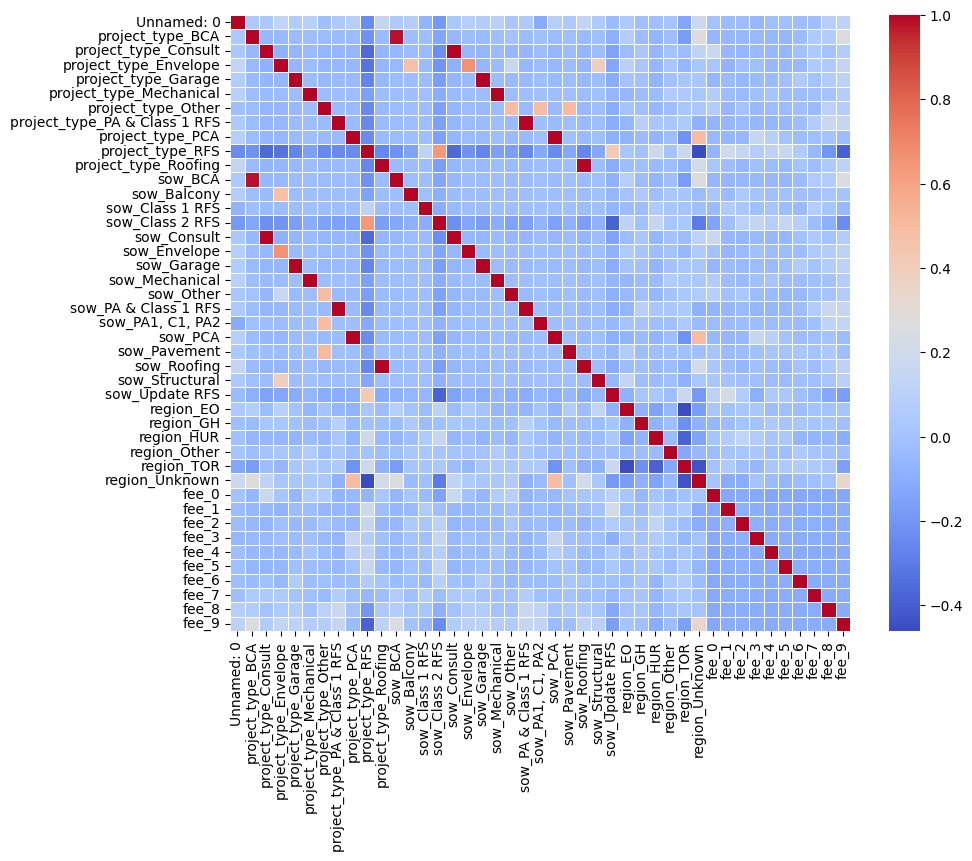

In [99]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)

There is a lot of overlap between sow and project_type dummies. This isn't hugely surprising since project_type is an aggregated form of sow. We'll remove the ones that do not offer a unique aggregation

In [100]:
X_train_all = X_train_all.drop(['project_type_BCA',
                                'project_type_Consult',
                                'project_type_Garage',
                                'project_type_Mechanical',
                                'project_type_Other',
                                'project_type_PCA',
                                'project_type_Roofing',
                                'project_type_Envelope'], axis=1)

In [101]:
X_test_all = X_test_all.drop(['project_type_BCA',
                                'project_type_Consult',
                                'project_type_Garage',
                                'project_type_Mechanical',
                                'project_type_Other',
                                'project_type_PCA',
                                'project_type_Roofing',
                                'project_type_Envelope'], axis=1)

The relationship between region_Unknown and the PCA project type is interesting. While I can't think of a reason for this, there is no harm in removing region_Unknown

In [102]:
X_train_all = X_train_all.drop('region_Unknown', axis=1)
X_test_all = X_test_all.drop('region_Unknown', axis=1)

In [108]:
print(X_train_all.shape)

(1780, 34)


# **RFS Multicollinearity Check**

In [104]:
correlation_matrix = X_train_rfs.corr()

<Axes: >

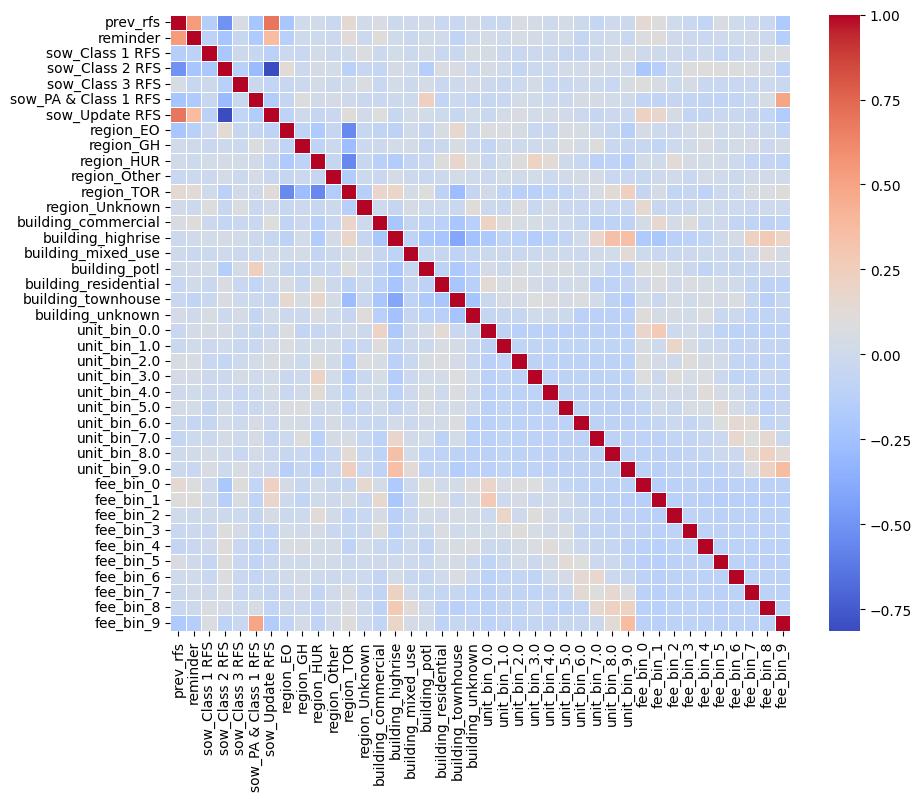

In [105]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)

The main worry here is the prev_rfs feature, which is correlated with both reminder and sow_Update RFS. This isn't surprising, since they can usually only send reminders for clients that they did the previous rfs for. These reminder proposals are also usually Update RFS type.

In [106]:
print('reminder and prev_rfs corr:', X_train_rfs['reminder'].corr(X_train_rfs['prev_rfs']))
print('Update RFS and prev_rfs corr:', X_train_rfs['sow_Update RFS'].corr(X_train_rfs['prev_rfs']))

reminder and prev_rfs corr: 0.5366803977810636
Update RFS and prev_rfs corr: 0.6890446046971238


The correlation isn't strong enough to require these features be removed. Each of these features adds unique value to the data, so I will keep them all as is

# **Data Export**

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
X_train_all.to_pickle('/content/drive/My Drive/shared_folder/X_train_all.pkl')
X_test_all.to_pickle('/content/drive/My Drive/shared_folder/X_test_all.pkl')
y_train_all.to_pickle('/content/drive/My Drive/shared_folder/y_train_all.pkl')
y_test_all.to_pickle('/content/drive/My Drive/shared_folder/y_test_all.pkl')

X_train_rfs.to_pickle('/content/drive/My Drive/shared_folder/X_train_rfs.pkl')
X_test_rfs.to_pickle('/content/drive/My Drive/shared_folder/X_test_rfs.pkl')
y_train_rfs.to_pickle('/content/drive/My Drive/shared_folder/y_train_rfs.pkl')
y_test_rfs.to_pickle('/content/drive/My Drive/shared_folder/y_test_rfs.pkl')